In [37]:
import pandas as pd
import numpy as np
import os
import re

# # Set working directory
# if not "/data/tables" in os.getcwd():
#     os.chdir("../data/tables")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [38]:
sdf = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")

In [39]:
sdf.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)



In [40]:
consumer_fraud_df = pd.read_csv("../data/tables/consumer_fraud_probability.csv")
merchant_fraud_df = pd.read_csv("../data/tables/merchant_fraud_probability.csv")

In [41]:
consumer_fraud_df.head(10)

,user_id,order_datetime,fraud_probability
0,6228,2021-12-19,97.629808
1,21419,2021-12-10,99.247380
2,5606,2021-10-17,84.058250
3,3101,2021-04-17,91.421921
4,22239,2021-10-19,94.703425
5,16556,2022-02-20,89.656633
6,10278,2021-09-28,83.591367
7,15790,2021-12-30,71.770659
8,5233,2021-08-29,85.871233
9,230,2021-08-28,86.283288


In [42]:
#merchant_fraud_df.head(20)
merchant_fraud_df[merchant_fraud_df["merchant_abn"] == 19492220327]
merchant_fraud_df.shape[0]

114

## Merchant Fraud
Check if there is missing data

In [43]:
merchant_sdf = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchant_sdf.printSchema()
merchant_df = merchant_sdf.toPandas()

root
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- merchant_abn: long (nullable = true)



In [44]:
#merchant_sdf.select("merchant_abn").distinct().count()
# 4026 entries distince values of merchant

fraud_union = set(merchant_fraud_df["merchant_abn"].unique()) # 61 unique cases
all_union = set(merchant_df["merchant_abn"].unique())
len(all_union.intersection(fraud_union))



48

Only 48/4026 merchants have fraud data
13/61 of the fraud data cannot be matched with any merchant abn

Try merge the merchant fraud data with transactions on order date + abn ????

## Costumer Fraud

In [45]:
costumer_sdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")
costumer_df = costumer_sdf.toPandas()
costumer_df.head()

,user_id,consumer_id
0,1,1195503
1,2,179208
2,3,1194530
3,4,154128
4,5,712975


In [46]:
# costumer_sdf.distinct().count() # 499999 distinc values

In [47]:
from pyspark.sql import functions as F
transaction_df1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot")
transaction_df2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot")
transaction_df3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot")
transaction = transaction_df1.union(transaction_df2).union(transaction_df3)

transaction = transaction.withColumn('log(dollar_value)',
                                     F.log(F.col('dollar_value')))
# lwr, upr = transaction.approxQuantile('log(dollar_value)', [0.25, 0.75], 0.001)
# iqr = upr - lwr
# lwr_bound = lwr - 1.5 * iqr
# upr_bound = upr + 1.5 * iqr
# lwr_bound, upr_bound = np.exp(lwr_bound), np.exp(upr_bound)

# new_transaction = transaction.where(
#     (F.col('dollar_value') >= lwr_bound) &
#     (F.col('dollar_value') <= upr_bound)
# )
merchant = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchant_abn = merchant.toPandas()['merchant_abn'].unique().tolist()
filtered_transaction = transaction.where(F.col('merchant_abn').isin(merchant_abn))
merchant_daily_transaction = filtered_transaction.groupby(['merchant_abn','order_datetime','user_id']).agg(
    F.countDistinct(F.col('order_id')).alias('no_order'),
    F.sum(F.col('dollar_value')).alias('dollar_amount')
) 


In [48]:
#merchant_daily_transaction.count() # 13584371

In [49]:
merchant_daily_transaction.head()

22/09/19 17:27:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 17:27:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 17:27:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 17:27:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 17:27:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 17:27:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 17:27:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 17:27:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 17:27:07 WARN RowBasedKeyValueBatch: Calling spill() on

Row(merchant_abn=13839274306, order_datetime=datetime.date(2021, 8, 20), user_id=3968, no_order=1, dollar_amount=88.4084826726033)

In [50]:
merchant_daily_transaction.select(max ('no_order'))

# MAX order is 3 

max(no_order)
3


The granularity level of the analysis is day level.

In [51]:
# entry 5 has high fraud rate, investigate this instance
# 82999039227,2021-12-19
# 35575706403,2022-02-20 entrie 43 
# 97884414539,2021-10-19,89.79919971536573

import datetime
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 35575706403)
    & (F.col('order_datetime') == "2022-02-20")
)

# print(35575706403 in merchant_abn)


merchant_abn,order_datetime,user_id,no_order,dollar_amount
35575706403,2022-02-20,16556,1,50209.505438673325


In [52]:
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
   & (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
19492220327,2021-11-28,21706,1,1903.7191517251547


In [53]:
merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
#    (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
    (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
27093785141,2021-08-19,21706,1,297.1060630006161
32656335530,2021-05-15,21706,1,45.95924058414554
14639489823,2022-05-10,21706,1,73.82891944981822
79269463423,2022-06-10,21706,1,192.44624685911833
46804135891,2021-11-12,21706,1,15.1040241409343
93561083066,2021-09-04,21706,1,71.9166019734691
86578477987,2022-06-27,21706,1,25.86363096512127
77013874702,2022-05-03,21706,1,3.684141987613139
92207241352,2021-08-22,21706,1,75.9671958496898
63465140133,2022-08-20,21706,1,8.25922769029275


0        250.808535
1        408.057444
2        438.018593
3        445.260618
4        481.082374
           ...     
819    34199.004178
820    34926.955075
821    35535.112447
822    38156.497147
823    43409.810489
Name: dollar_amount, Length: 824, dtype: float64


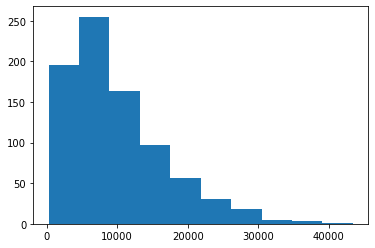

In [54]:
test_dollar_amout = merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('merchant_abn') == 19492220327)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
#    & (F.col('user_id') == 21706)
).select("dollar_amount").toPandas()

import matplotlib.pyplot as plt



sorted = test_dollar_amout.sort_values(by="dollar_amount").reset_index()["dollar_amount"]
# plt.plot(sorted)
plt.hist(sorted) # mixure model?
# print(test_dollar_amout.mean())
# print(test_dollar_amout.std())
print(sorted)

# transaction level fraud detection
### idea 1 


fit a kmeans model to each merchant using ADK(automatic determination of Kmeans. granularity level is month since sku is unlikely to change too often), find std of each cluster, each cluster is seen as a normal distribution. 

When new transaction data come, first sort it to one cluster, then use quantile method of normal to determine the probability of it being a fraud.



### idea 2

Based on bayesian statistic. Fit a distribution (start with poisson) to every merchant. Use quantile method 


In [55]:
# user_id,order_datetime,fraud_probability
# 6228,2021-12-19,97.6298077657765 investigate this

merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('user_id') == 6228)
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
   # &
   # (F.col('order_datetime') == datetime.date(2021, 12, 19))
 & (F.col('dollar_amount') <= 1279.315571)
& (F.col('dollar_amount') >= 1277.315571)

#    & (F.col('user_id') == 21706)
)

merchant_abn,order_datetime,user_id,no_order,dollar_amount
81776569986,2021-03-03,6228,1,1278.315571140402


,dollar_amount
0,502.107659
1,1278.315571
2,62.893256
3,230.216561
4,84.566328
...,...
553,74.979890
554,75.176187
555,60.498921
556,75.781941


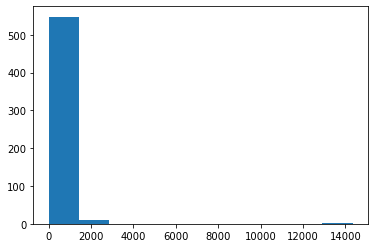

In [56]:
consumer = merchant_daily_transaction.where(
   # != 0 is fine, but let's also take into account some more realistic filters
   (F.col('user_id') == 6228)
  
   # & (F.col('order_datetime') == datetime.date(2021, 11, 28)
#    &
#    (F.col('order_datetime') == datetime.date(2021, 12, 19))
#    & (F.col('user_id') == 21706)
).select("dollar_amount").toPandas()

plt.hist(consumer["dollar_amount"]) 
consumer

# For Sprint 

## Mechant Data

In [57]:
# join merchant daily transaction data and merchant fraud
merchant_fraud_df.to_parquet("../data/temp/merchant_fraud")

merchant_fraud_sdf = spark.read.parquet("../data/temp/merchant_fraud")


In [58]:
# join merchant daily transaction data and merchant fraud
#join_df = merchant_fraud_sdf.join(merchant_daily_transaction, on=["merchant_abn","order_datetime"])
# join_df.count() #3981

join_df = merchant_fraud_sdf.join(merchant_daily_transaction, on=["merchant_abn","order_datetime"]).distinct()
# join_df.select("merchant_abn").distinct().count() #48
join_df.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- user_id: long (nullable = true)
 |-- no_order: long (nullable = false)
 |-- dollar_amount: double (nullable = true)



In [59]:
# join dataframe only contains merchant transaction contained in merchant_fraud data
agg_sdf = join_df.groupBy(['merchant_abn','order_datetime']).agg(
     F.countDistinct(F.col('user_id')).alias('no_customer'),
     F.sum(F.col("no_order")).alias("total_order"),
     F.avg(F.col("dollar_amount")).alias("avg_dollar_amount"), # changed to avg for independence
     F.mean(F.col("fraud_probability")).alias("fraud_prob")
)

agg_sdf.count() # 95


#total_dollar_amount

95

In [60]:
agg_sdf.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- order_datetime: string (nullable = true)
 |-- no_customer: long (nullable = false)
 |-- total_order: long (nullable = true)
 |-- avg_dollar_amount: double (nullable = true)
 |-- fraud_prob: double (nullable = true)



(array([ 7., 43., 17.,  5.,  3.,  3., 12.,  2.,  1.,  2.]),
 array([18.21089143, 25.49940913, 32.78792684, 40.07644454, 47.36496225,
        54.65347995, 61.94199765, 69.23051536, 76.51903306, 83.80755077,
        91.09606847]),
 <BarContainer object of 10 artists>)

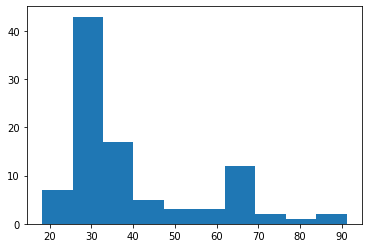

In [61]:
# histogram of fraud distribution
agg_df = agg_sdf.toPandas()

plt.hist(agg_df["fraud_prob"])

In [62]:
filtered_transaction.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- log(dollar_value): double (nullable = true)



### standardize customer number, total order, total_dollar_amount by its mean and var

In [63]:
# first find the average 
labeled_merchant = merchant_fraud_df['merchant_abn'].unique().tolist()
labeled_merchant_transaction = transaction.where(F.col('merchant_abn').isin(labeled_merchant))

all_time_daily_merchant_transaction = labeled_merchant_transaction.groupby(['merchant_abn','order_datetime']).agg(
    F.countDistinct(F.col('user_id')).alias('no_customer'),
    F.countDistinct(F.col("order_id")).alias("total_order"),
    F.avg(F.col("dollar_value")).alias("avg_dollar_value"), # changed to average per consumer for independence
) 

all_time_daily_merchant_transaction.count()

18656

In [64]:
all_time_agg = all_time_daily_merchant_transaction.groupBy("merchant_abn").agg(
    F.avg(F.col("no_customer")).alias("avg_daily_no_customer"),
    F.stddev(F.col("no_customer")).alias("stddev_daily_no_customer"),
    F.avg(F.col("total_order")).alias("avg_daily_total_order"),
    F.stddev(F.col("total_order")).alias("stddev_daily_total_order"),
    F.avg(F.col("avg_dollar_value")).alias("avg_daily_avg_dollar_value"), # avg customer spending
    F.stddev(F.col("avg_dollar_value")).alias("stddev_daily_avg_dollar_value"),
)

all_time_agg.printSchema()


root
 |-- merchant_abn: long (nullable = true)
 |-- avg_daily_no_customer: double (nullable = true)
 |-- stddev_daily_no_customer: double (nullable = true)
 |-- avg_daily_total_order: double (nullable = true)
 |-- stddev_daily_total_order: double (nullable = true)
 |-- avg_daily_avg_dollar_value: double (nullable = true)
 |-- stddev_daily_avg_dollar_value: double (nullable = true)



In [65]:
#all_time_agg.count() # 61 checked
all_time_agg_df = all_time_agg.toPandas()

In [66]:
agg_df.head(1)

,merchant_abn,order_datetime,no_customer,total_order,avg_dollar_amount,fraud_prob
0,27093785141,2021-11-27,116,117,400.528232,29.539473


In [81]:
# discuss about the modeling idea during standup, use normal(t test) for now
# Joint probability 
# assume independence (avg spending and number of customer are independent )
# cdf F(x<X, y<Y) = F(x)F(y)
# since order and customer are highly correlated(almost identical), we choose avg_dollar_value as X and 
# no of orders as Y



from scipy import stats
def two_side_p_val(mean, stddev, test):
    norm_dist = stats.norm(loc=mean, scale=stddev)
    if test > mean:
        return 2* (1-norm_dist.cdf(test))
    else:
        return 2*norm_dist.cdf(test)

def join_prob_p_val(mux, stdx, muy, stdy, testx, testy):
    distx = stats.norm(loc=mux, scale=stdx)
    disty = stats.norm(loc=muy, scale=stdy)
    joint_prob = distx.cdf(testx) * disty.cdf(testy)
    if joint_prob>0.5:
        return 2* (1-joint_prob)
    else:
        return 2*joint_prob


agg_join_df = all_time_agg_df.merge(agg_df, on="merchant_abn")

agg_join_df["no_order_p_val"] = agg_join_df[['avg_daily_total_order','stddev_daily_total_order',"total_order"]].\
    apply(lambda row:two_side_p_val(row[0],row[1],row[2]),axis=1)

agg_join_df["no_customer_p_val"] = agg_join_df[['avg_daily_no_customer','stddev_daily_no_customer',"no_customer"]].\
    apply(lambda row:two_side_p_val(row[0],row[1],row[2]),axis=1)

agg_join_df["avg_dollar_value_p_val"] = agg_join_df[['avg_daily_avg_dollar_value','stddev_daily_avg_dollar_value',"avg_dollar_amount"]].\
    apply(lambda row:two_side_p_val(row[0],row[1],row[2]),axis=1)


# not good feature
agg_join_df["joint_dist_p_val"] =  agg_join_df[['avg_daily_avg_dollar_value','stddev_daily_avg_dollar_value',\
    'avg_daily_total_order','stddev_daily_total_order','avg_dollar_amount',"total_order"]].\
         apply(lambda row:join_prob_p_val(row[0],row[1],row[2],row[3],row[4],row[5]),axis=1)

# # p_val_x * p_val_y
# agg_join_df["p_val_multiple"] = agg_join_df[['avg_dollar_value_p_val','no_order_p_val']].apply(lambda row:
# np.exp(row[0])*np.exp(row[1]),axis=1)




/Users/ke/opt/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/ke/opt/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/Users/ke/opt/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [68]:
# just one transaction, so dev is nan
transaction.where(
    F.col("merchant_abn") == 67264251405
)

user_id,merchant_abn,dollar_value,order_id,order_datetime,log(dollar_value)
22239,67264251405,51876.637563877644,09206be9-492c-414...,2021-10-19,10.856623824531193


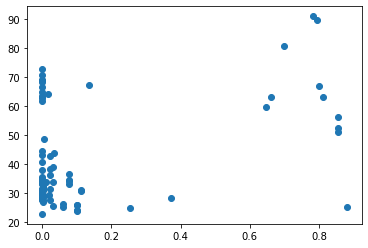

In [69]:
# graphs
agg_join_df = agg_join_df.dropna()
plt.scatter(agg_join_df["no_order_p_val"],agg_join_df["fraud_prob"])
# agg_join_df["no_order_p_val"] = agg_join_df["no_order_p_val"]

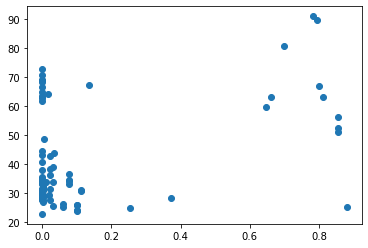

In [70]:
plt.scatter(agg_join_df["no_customer_p_val"],agg_join_df["fraud_prob"])

#plt.scatter(np.log(agg_join_df["no_customer_p_val"]),agg_join_df["fraud_prob"])

In [71]:
agg_join_df.loc[agg_join_df["fraud_prob"] >= 90]

,merchant_abn,avg_daily_no_customer,stddev_daily_no_customer,avg_daily_total_order,stddev_daily_total_order,avg_daily_avg_dollar_value,stddev_daily_avg_dollar_value,order_datetime,no_customer,total_order,avg_dollar_amount,fraud_prob,no_order_p_val,no_customer_p_val,avg_dollar_value_p_val
36,35575706403,1.072464,0.261154,1.072464,0.261154,11275.779495,8551.62989,2022-02-20,1,1,50209.505439,91.096068,0.781415,0.781415,0.000005


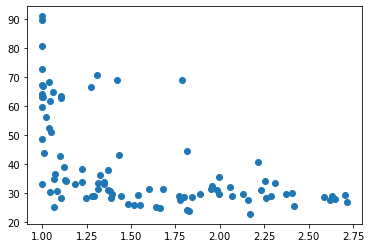

In [92]:
plt.scatter(np.exp(agg_join_df["avg_dollar_value_p_val"]),agg_join_df["fraud_prob"])
# plt.scatter(np.log(agg_join_df["total_dollar_value_p_val"]),agg_join_df["fraud_prob"])


In [73]:
# Joint probability 
# assume independence (avg spending and number of customer are independent )
# cdf F(x<X, y<Y) = F(x)F(y)



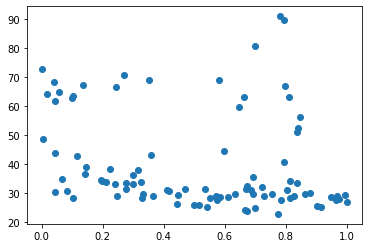

In [75]:
# not optimal....
plt.scatter(agg_join_df["joint_p_val"],agg_join_df["fraud_prob"])

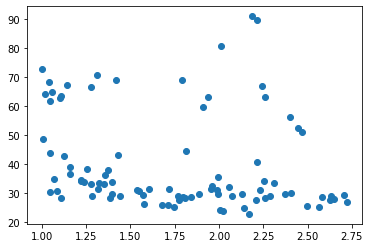

In [82]:
# # p val multiple

# plt.scatter(agg_join_df["p_val_multiple"],agg_join_df["fraud_prob"])

dollar amount it self has a nice negtaive relation
when we use joint prob it is almost uniformly distributed
it appears to be the dollar amount is the most significant feature in terms of determine fraud

## Customer data

# Semi Supervised SVM Idea
### Features
#### Coming from merchant: 
no_order_p_val, no_customer_p_val, total_dollar_value_p_val

#### Coming from customer(discounted by fraudulent probability):
fraud_customer_share
fraud_order_share
fraud_dollar_amount_share

### Method
